In [128]:
import os
import sys
import shutil
os.environ['TOKENIZERS_PARALLELISM'] = "False"

import torch
import pandas as pd
import numpy as np
import json
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

from typing import Dict, Union, List, Any
import shared.utils as su

In [129]:
# Load data: SSv2
from notebooks.eval_care_retrieval import load_data
df = load_data(dataset='ssv2')
df.shape

Number of rows:  1430
Sample row: 
{
    "id": 69703,
    "label": "moving pen up",
    "template": "Moving [something] up",
    "placeholders": "['pen']",
    "target": 114,
    "chiral_label": 0.0,
    "chiral_triplet_id": "3f20f09b",
    "noun": "['something']",
    "text_id": "3f20f09b_0.0",
    "video_path": "/scratch/shared/beegfs/piyush/datasets/SSv2/20bn-something-something-v2/69703.webm"
}


(1430, 10)

In [130]:
video_paths = df.video_path.tolist()
text_captions = df.label.tolist()
len(video_paths), len(text_captions)

(1430, 1430)

**Load model**

In [131]:
from models.modeling_encoders import AutoEncoder

# model_id = '/work/piyush/pretrained_checkpoints/Tarsier-7b'
model_id = "/work/piyush/experiments/CaRe/Tarsier-7b/nli-9k+ego4d-1k/merged_checkpoint"
encoder = AutoEncoder.from_pretrained(model_id, device_map='cuda:0')
su.misc.num_params(encoder.model)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading EncoderForTarsier from /work/piyush/experiments/CaRe/Tarsier-7b/nli-9k+ego4d-1k/merged_checkpoint
### do_image_padding is set as False, images will be resized directly!


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

::: Number of total parameters in TarsierForConditionalGeneration: 7063.427M


#### 1. Analyse embeddings using the last token (no prompt)

In [132]:
from utils.model import transform_pixel_values
from utils.video import read_frames_decord
from torchvision.transforms.v2 import (
    ToPILImage,
    functional,
)

In [133]:
video_tensor = read_frames_decord(
    '../../TimeBound.v1/sample_data/folding_paper.mp4', 16,
)
video_tensor.shape

torch.Size([16, 3, 240, 426])

In [134]:
text = 'This is an example video.'

In [135]:
DRY_PROMPT = "USER: <video>\nASSISTANT: "
print(DRY_PROMPT)

USER: <video>
ASSISTANT: 


In [136]:
DRY_PROMPT_TEXT = "USER: <sent>\nASSISTANT: "
print(DRY_PROMPT_TEXT)

USER: <sent>
ASSISTANT: 


In [137]:
def encode_vision_custom_prompt(encoder, pixel_values, prompt=DRY_PROMPT):

    pixel_values = transform_pixel_values(pixel_values) # [B, T, C, H, W]
    nframes = pixel_values.shape[1]

    to_image = ToPILImage()
    batched_frames = []
    for batch in pixel_values:
        frames = [to_image(v) for v in batch]
        batched_frames.append(frames)

    generate_kwargs = {
        "max_new_tokens": 1,
        "output_hidden_states": True,
        "return_dict_in_generate": True,
    }

    vision_embs = []

    for frames in batched_frames:
        input_prompt = prompt.replace("<video>", "<image>"*len(frames))
        input_ids = encoder.processor.get_text_inputs(input_prompt)
        frames = encoder.processor.get_pixel_values(frames)
        inputs = {
            "input_ids": input_ids,
            "pixel_values": frames
        }
        inputs = {k:v.to(encoder.model.device) for k,v in inputs.items() if v is not None}
        outputs = encoder.model.generate(
            **inputs,
            **generate_kwargs,
        )
        vision_embs.append(outputs.hidden_states[0][-1][:, -1, :])
    
    vision_embs = torch.cat(vision_embs)
    return vision_embs


def encode_text_custom_prompt(encoder, text, prompt=DRY_PROMPT_TEXT):

    if isinstance(text, str):
        text = [text]
    
    prompts = [prompt.replace('<sent>', t) for t in text]

    generate_kwargs = {
        "max_new_tokens": 1,
        "output_hidden_states": True,
        "return_dict_in_generate": True,
    }

    text_embs = []

    for p in prompts:
        text_inputs = encoder.processor.get_text_inputs(p)
        inputs = {
            "input_ids": text_inputs,
        }
        inputs = {k:v.to(encoder.model.device) for k,v in inputs.items() if v is not None}
        outputs = encoder.model.generate(
            **inputs,
            **generate_kwargs,
        )
        text_embs.append(outputs.hidden_states[0][-1][:, -1, :])
    
    text_embs = torch.cat(text_embs)
    return text_embs


In [138]:
# video_tensor_dense = read_frames_decord(
#     '../../TimeBound.v1/sample_data/folding_paper.mp4', 50,
# )


def postprocess_embed(z):
    return torch.nn.functional.normalize(z, dim=-1).cpu().float().squeeze(0)


with torch.no_grad():
    # zv = encode_vision_custom_prompt(encoder, video_tensor.unsqueeze(0), prompt=DRY_PROMPT)
    zv = encode_vision_custom_prompt(encoder, video_tensor, prompt=DRY_PROMPT)
    zv = postprocess_embed(zv)
    
    # zv = encode_vision_no_prompt(encoder, video_tensor_dense)
    # zv = torch.nn.functional.normalize(zv, dim=-1).cpu().float().squeeze(0)

    zt = encode_text_custom_prompt(encoder, text, prompt=DRY_PROMPT_TEXT)
    zt = postprocess_embed(zt)

zv.shape, zt.shape

(torch.Size([16, 4096]), torch.Size([4096]))

**Visualize modality gap with dry prompt**

In [139]:
video_paths = np.unique(video_paths)
text_captions = np.unique(text_captions)
len(text_captions), len(video_paths)

(439, 1430)

In [140]:
texts_embed = {}
for text in su.log.tqdm_iterator(text_captions, desc='Computing text features'):
    with torch.no_grad():
        zt = encode_text_custom_prompt(encoder, text, prompt=DRY_PROMPT_TEXT)
        zt = postprocess_embed(zt)
    texts_embed[text] = zt


video_embed = {}
for video_path in su.log.tqdm_iterator(video_paths, desc='Computing video features'):
    with torch.no_grad():
        video_tensor = read_frames_decord(video_path, 8).unsqueeze(0)
        zv = encode_vision_custom_prompt(encoder, video_tensor, prompt=DRY_PROMPT)
        zv = postprocess_embed(zv)
    video_embed[video_path] = zv

len(video_embed), len(texts_embed)

Computing text features:   0%|          | 0/439 [00:00<?, ?it/s]

Computing video features:   0%|          | 0/1430 [00:00<?, ?it/s]

(1430, 439)

In [141]:
prompt_eol_vision = encoder.video_eol_prompt
prompt_eol_text = encoder.text_eol_prompt
print(prompt_eol_vision), print(prompt_eol_text)

USER: <video>
Summary above video in one word: ASSISTANT: 
USER: <sent>
Summary above sentence in one word: ASSISTANT: 


(None, None)

In [142]:
video_embed_eol = {}
for video_path in su.log.tqdm_iterator(video_paths, desc='Computing video features'):
    with torch.no_grad():
        video_tensor = read_frames_decord(video_path, 8).unsqueeze(0)
        zv = encode_vision_custom_prompt(encoder, video_tensor, prompt=prompt_eol_vision)
        zv = postprocess_embed(zv)
    video_embed_eol[video_path] = zv


texts_embed_eol = {}
for text in su.log.tqdm_iterator(text_captions, desc='Computing text features'):
    with torch.no_grad():
        zt = encode_text_custom_prompt(encoder, text, prompt=prompt_eol_text)
        zt = postprocess_embed(zt)
    texts_embed_eol[text] = zt

len(video_embed_eol), len(texts_embed_eol)

Computing video features:   0%|          | 0/1430 [00:00<?, ?it/s]

Computing text features:   0%|          | 0/439 [00:00<?, ?it/s]

(1430, 439)

### Plotting

In [ ]:
# ZV = torch.stack([video_embed_eol[f] for f in video_embed_eol])
# ZT = torch.stack([texts_embed_eol[t] for t in texts_embed_eol])
# Z = torch.concatenate([ZV, ZT], dim=0)
# z = su.visualize.reduce_dim(Z, method='tsne')
# Z.shape, z.shape

# fig, ax = plt.subplots(1, 1, figsize=(6, 5))
# ax.scatter(z[:len(ZV), 0], z[:len(ZV), 1], s=8, label='Video')
# ax.scatter(z[len(ZV):, 0], z[len(ZV):, 1], s=8, label='Text')
# ax.grid(alpha=0.3)
# ax.set_xlabel("$\\mathbf{z}_{1}$")
# ax.set_ylabel("$\\mathbf{z}_{2}$")
# ax.legend(fontsize=12)
# ax.set_title("2D tSNE projection of Tarsier embeddings", fontsize=14)
# # plt.savefig("../figures/tsne-tarsier7b_ssv2_cia-dry_prompt-v1.pdf", bbox_inches='tight')
# # plt.savefig("../figures/tsne-tarsier7b+tara_ssv2_cia-eol_prompt-v1.pdf", bbox_inches='tight')
# plt.show()

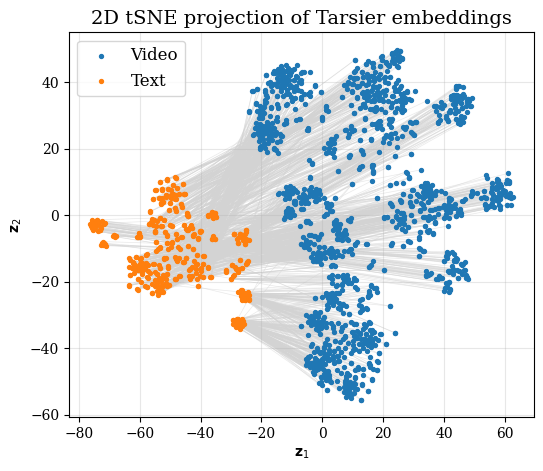

In [147]:
_video_embeds = video_embed
_texts_embeds = texts_embed
# _video_embeds = video_embed_eol
# _texts_embeds = texts_embed_eol


ZV = torch.stack([_video_embeds[f] for f in _video_embeds])
ZT = torch.stack([_texts_embeds[t] for t in _texts_embeds])
Z = torch.concatenate([ZV, ZT], dim=0)
z = su.visualize.reduce_dim(Z, method='tsne')
Z.shape, z.shape

vid2text = {}
for f in _video_embeds:
    vid2text[f] = df[df.video_path == f].iloc[0].label
len(vid2text)

# Create mappings from video/text to their index in z
video_list = list(_video_embeds.keys())
text_list = list(_texts_embeds.keys())

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# Draw matching lines first (so they appear behind the points)
for i, f in enumerate(video_list):
    matched_text = vid2text[f]
    if matched_text in text_list:
        j = text_list.index(matched_text)
        # Draw line from video point to text point
        ax.plot([z[i, 0], z[len(ZV) + j, 0]], 
                [z[i, 1], z[len(ZV) + j, 1]], 
                color='lightgray', linewidth=0.5, alpha=0.5, zorder=1)

# Draw scatter points on top
ax.scatter(z[:len(ZV), 0], z[:len(ZV), 1], s=8, label='Video', zorder=2)
ax.scatter(z[len(ZV):, 0], z[len(ZV):, 1], s=8, label='Text', zorder=2)

ax.grid(alpha=0.3)
ax.set_xlabel("$\\mathbf{z}_{1}$")
ax.set_ylabel("$\\mathbf{z}_{2}$")
ax.legend(fontsize=12)
ax.set_title("2D tSNE projection of Tarsier embeddings", fontsize=14)
plt.savefig("../figures/tsne-tarsier7b+tara_ssv2_cia-dry_prompt-matched-v1.pdf", bbox_inches='tight')
plt.show()

In [185]:
# triplet_id = '12055391'
triplet_id = '677ffe97'
# triplet_id = np.random.choice(df.chiral_triplet_id.unique())

_video_embeds = video_embed
_texts_embeds = texts_embed
# _video_embeds = video_embed_eol
# _texts_embeds = texts_embed_eol

video_paths_pos = df[(df.chiral_triplet_id == triplet_id) & (df.chiral_label == 1.)].video_path.tolist()
video_paths_neg = df[(df.chiral_triplet_id == triplet_id) & (df.chiral_label == 0.)].video_path.tolist()
zv_pos = torch.stack([_video_embeds[f] for f in video_paths_pos])
zv_neg = torch.stack([_video_embeds[f] for f in video_paths_neg])
zv = torch.cat([zv_pos, zv_neg])

len(video_paths_pos), len(video_paths_neg), zv.shape

(25, 35, torch.Size([60, 4096]))

In [186]:
zv_tsne = su.visualize.reduce_dim(zv)

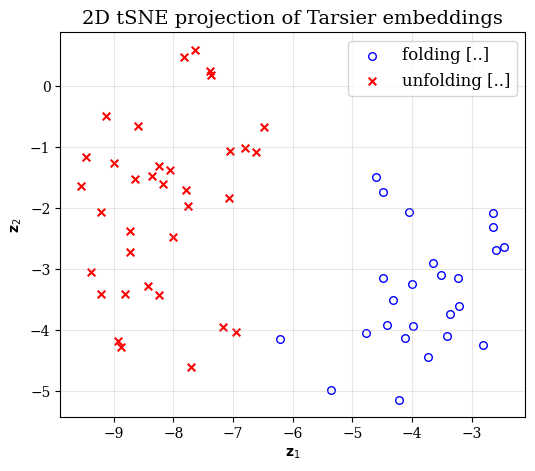

In [187]:
n = len(zv_pos)
s = 30

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(zv_tsne[:n, 0], zv_tsne[:n, 1], s=s, label='folding [..]', color='blue', marker='o', facecolor='white')
ax.scatter(zv_tsne[n:, 0], zv_tsne[n:, 1], s=s, label='unfolding [..]', color='red', marker='x')
ax.grid(alpha=0.3)
ax.set_xlabel("$\\mathbf{z}_{1}$")
ax.set_ylabel("$\\mathbf{z}_{2}$")
ax.legend(fontsize=12)
ax.set_title("2D tSNE projection of Tarsier embeddings", fontsize=14)
# plt.savefig(f"../figures/tsne-tarsier7b+tara_ssv2_cia_{triplet_id}_eol_prompt-v1.pdf", bbox_inches='tight')
plt.show()

In [183]:
triplet_id

'677ffe97'

In [79]:
!mkdir -p ../figures/